In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra`
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [2]:
import warnings 
warnings.filterwarnings("ignore")


## 1. Loading training data

In [3]:
# load dataset
dataset=pd.read_csv(r'../input/home-data-for-ml-course/train.csv')
pd.set_option('max_columns',200)

In [4]:
# copy dataset into train
train=dataset.copy()

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. EDA 

## 2. a) Exploring features

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [7]:
train.shape

(1460, 81)

In [8]:
train.isnull().sum().any()

True

In [9]:
# selecting num features 
num_features=train.select_dtypes(('int','float')).columns
num_features

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [10]:
# selecting categorical features
cat_features=train.select_dtypes(('object','bool')).columns
cat_features

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [11]:
train[num_features].isnull().sum()

Id                 0
MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [12]:
train[num_features].nunique()

Id               1460
MSSubClass         15
LotFrontage       110
LotArea          1073
OverallQual        10
OverallCond         9
YearBuilt         112
YearRemodAdd       61
MasVnrArea        327
BsmtFinSF1        637
BsmtFinSF2        144
BsmtUnfSF         780
TotalBsmtSF       721
1stFlrSF          753
2ndFlrSF          417
LowQualFinSF       24
GrLivArea         861
BsmtFullBath        4
BsmtHalfBath        3
FullBath            4
HalfBath            3
BedroomAbvGr        8
KitchenAbvGr        4
TotRmsAbvGrd       12
Fireplaces          4
GarageYrBlt        97
GarageCars          5
GarageArea        441
WoodDeckSF        274
OpenPorchSF       202
EnclosedPorch     120
3SsnPorch          20
ScreenPorch        76
PoolArea            8
MiscVal            21
MoSold             12
YrSold              5
SalePrice         663
dtype: int64

## 2. b) Plotting features

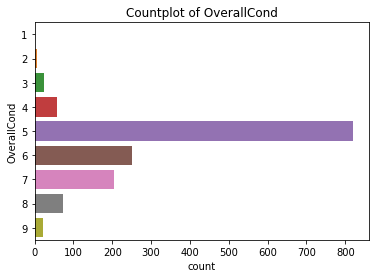

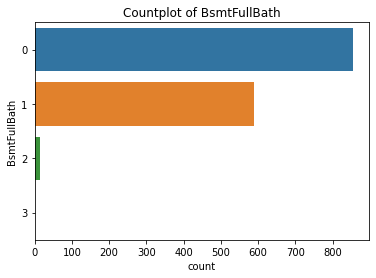

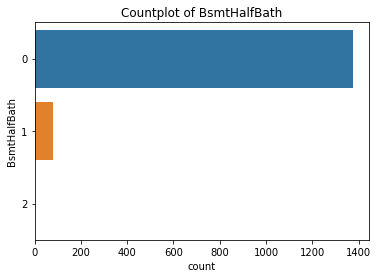

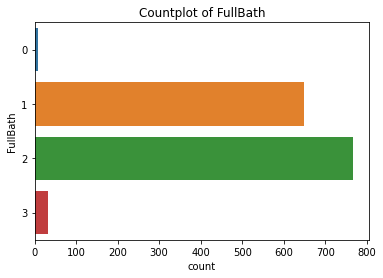

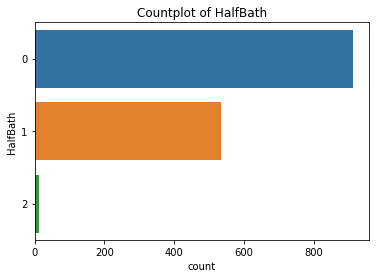

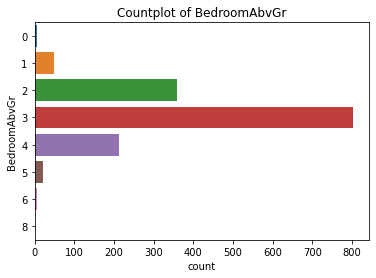

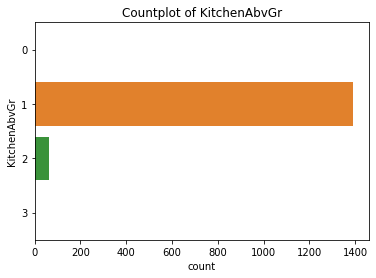

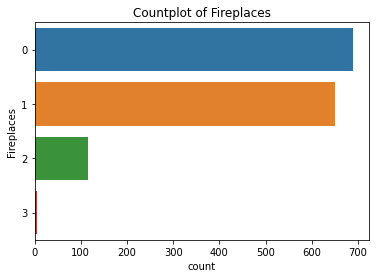

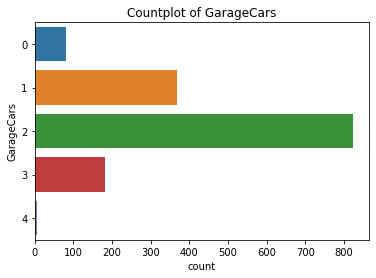

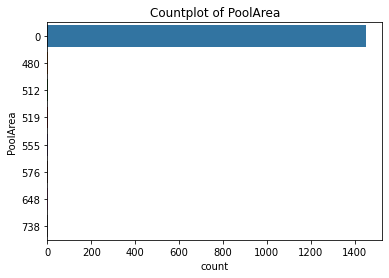

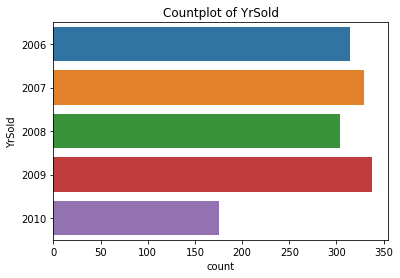

In [13]:
# plotting num features with less than 10 unique values with countplot
for feature in num_features:
    if train[feature].nunique()<10:
        plt.title(f'Countplot of {feature}')
        sns.countplot(y=train[feature])
        plt.show()

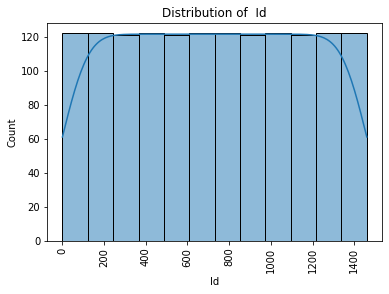

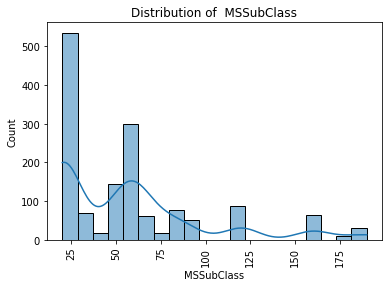

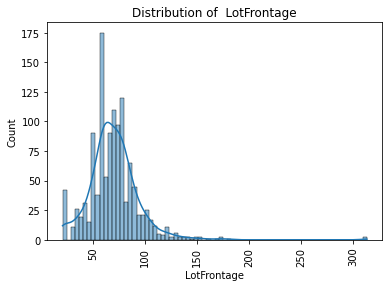

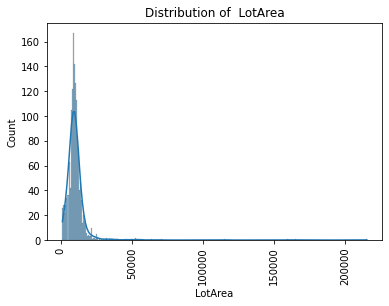

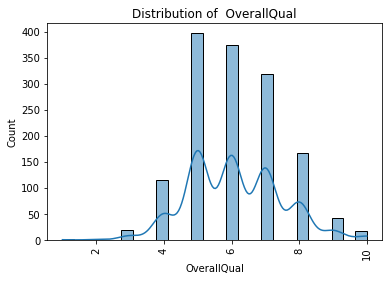

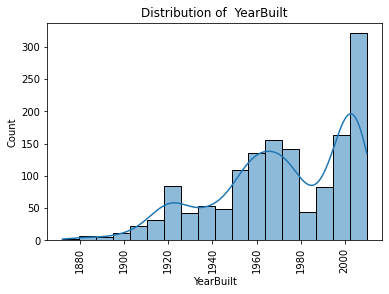

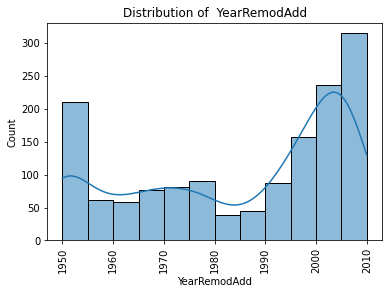

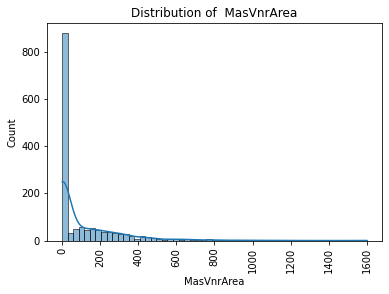

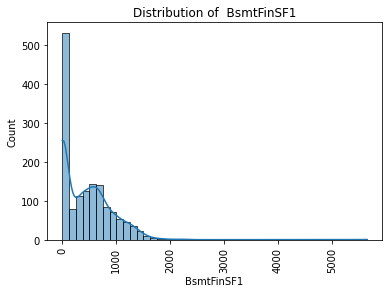

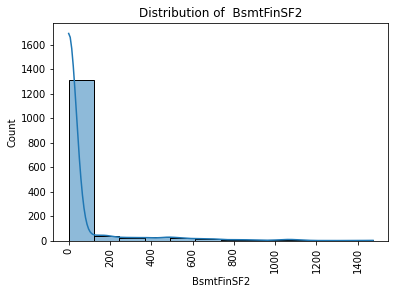

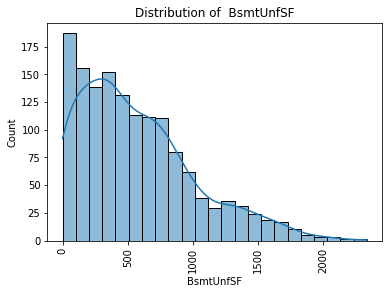

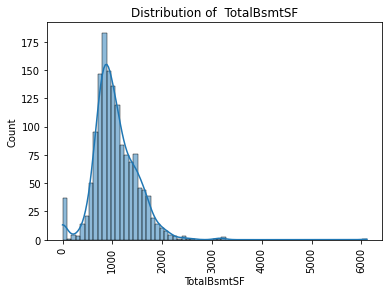

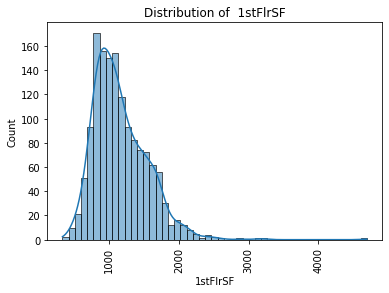

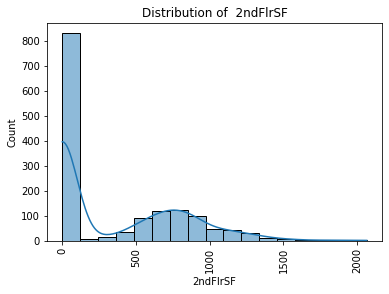

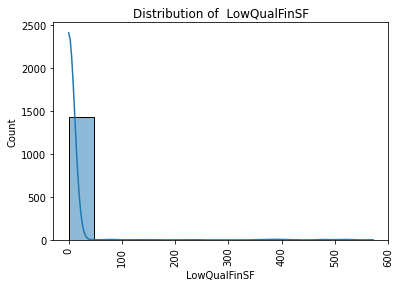

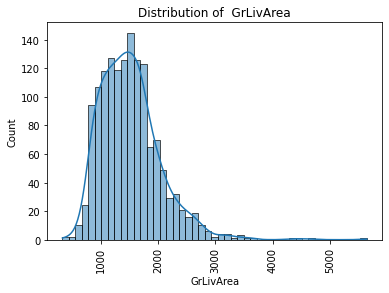

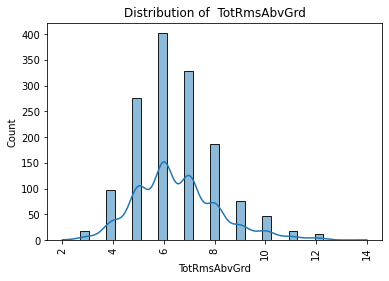

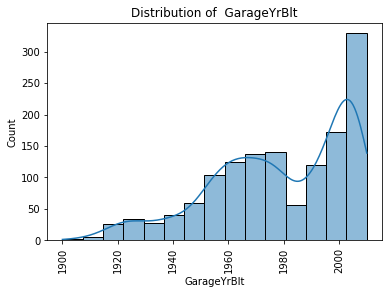

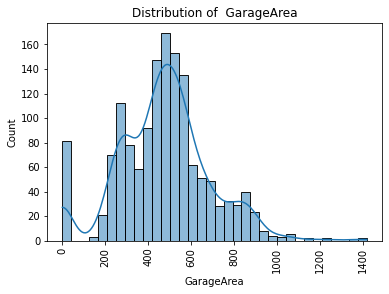

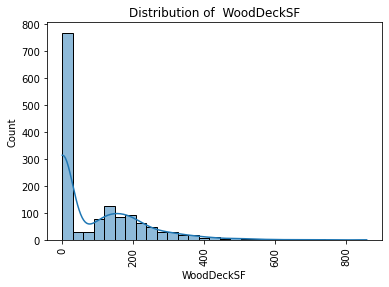

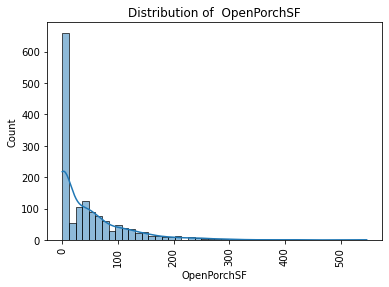

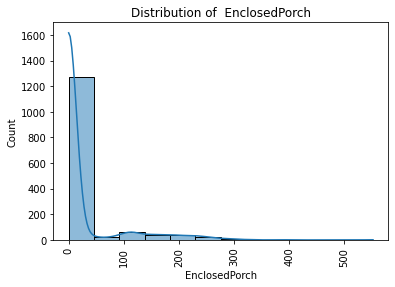

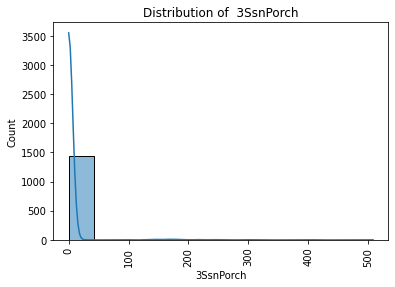

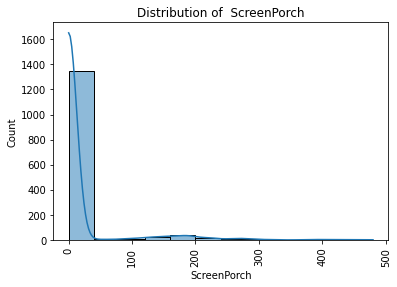

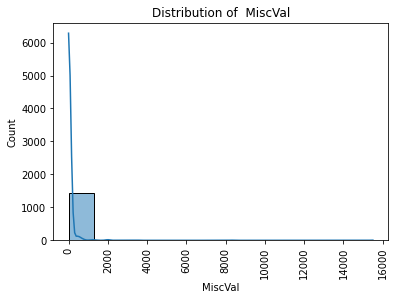

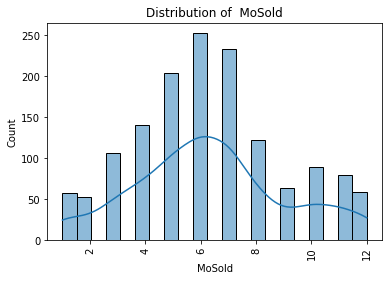

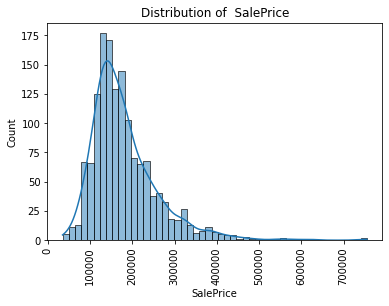

In [14]:
# plotting num features with 10 or more unique values with histplot 
for feature in num_features:
    if train[feature].nunique()>=10:
        plt.title(f'Distribution of  {feature}')
        plt.xticks(rotation=90)
        plt.xlabel(feature)
        sns.histplot(x=train[feature],kde=True)
        plt.show()

In [15]:
train[cat_features].isnull().sum() 

MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       690
GarageType         81
GarageFinish       81
GarageQual         81
GarageCond         81
PavedDrive          0
PoolQC           1453
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
dtype: int64

In [16]:
train[cat_features].nunique()

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

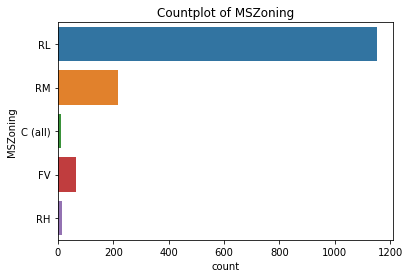

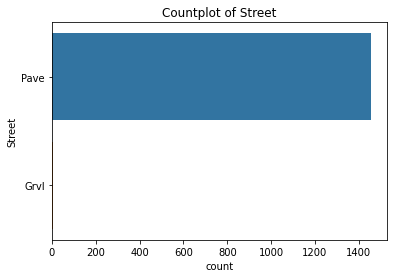

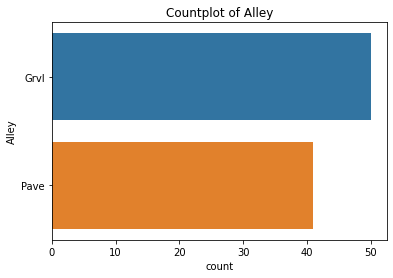

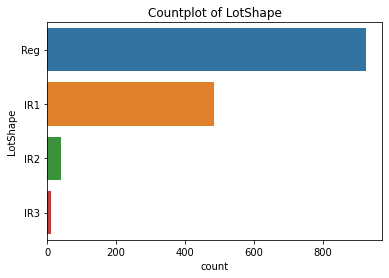

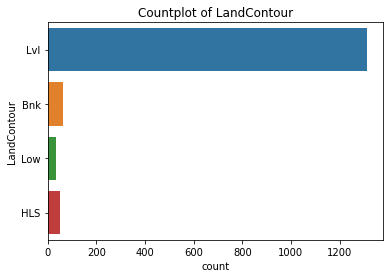

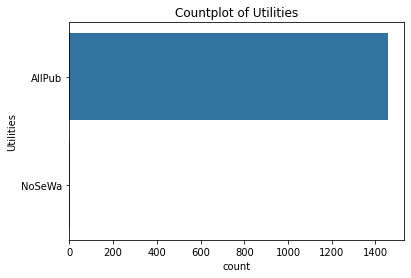

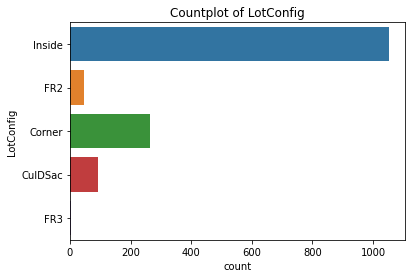

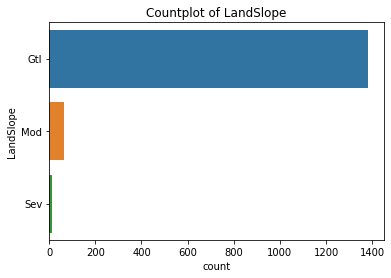

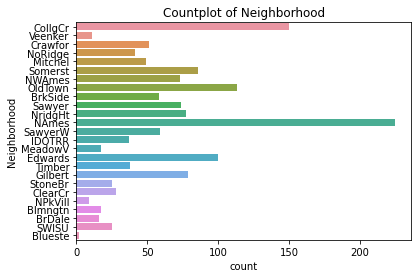

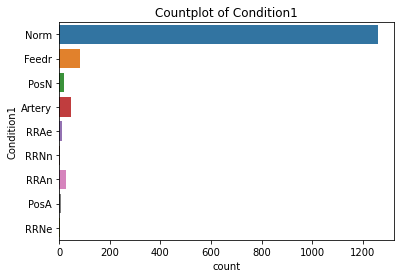

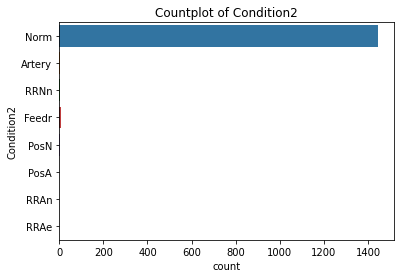

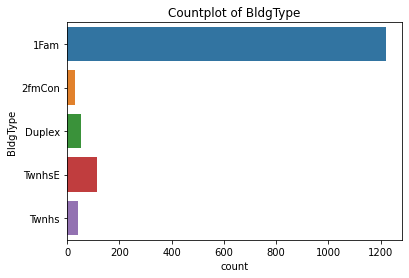

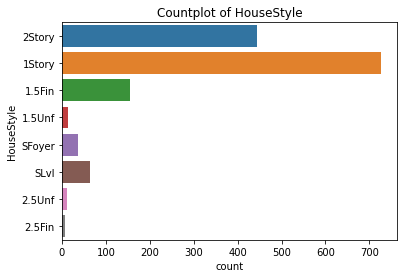

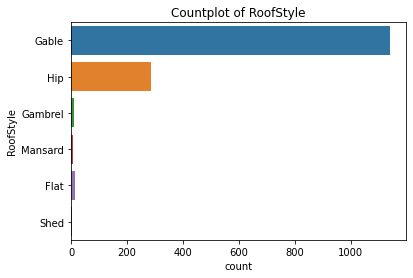

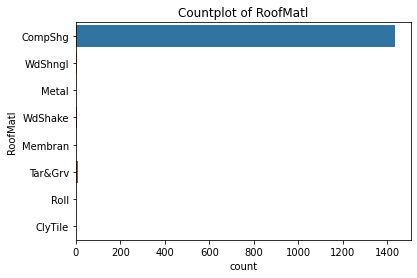

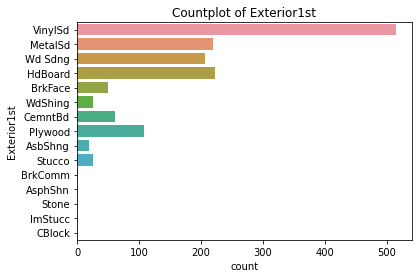

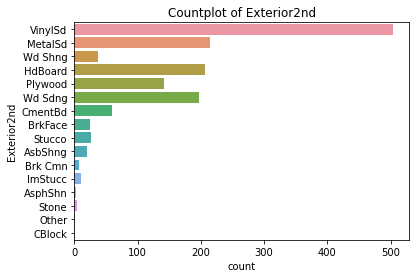

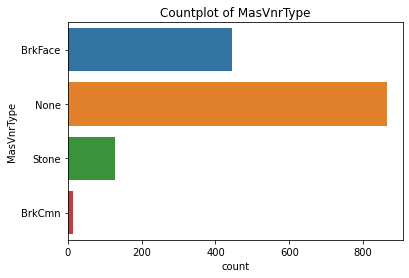

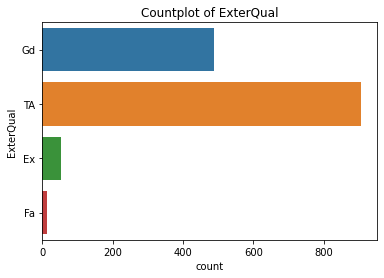

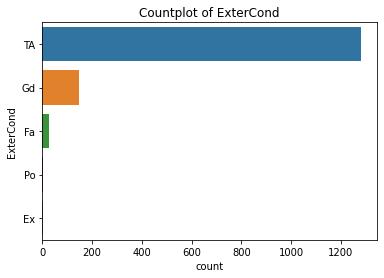

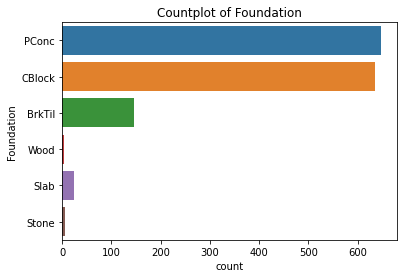

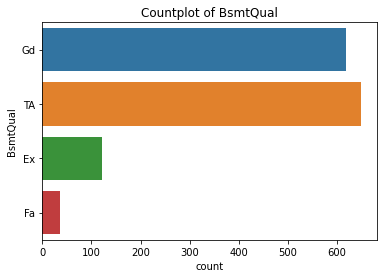

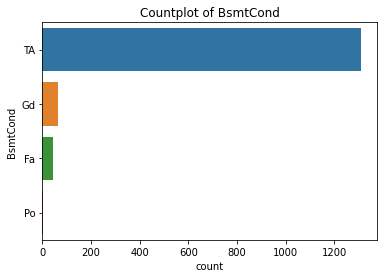

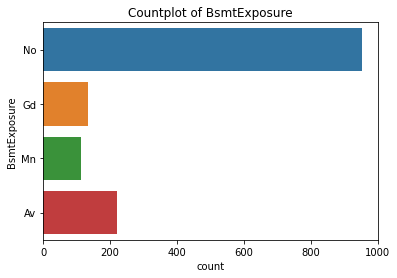

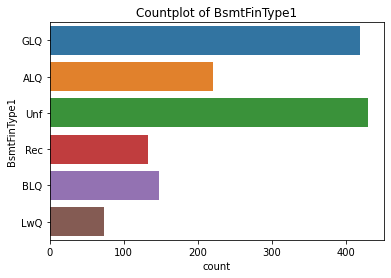

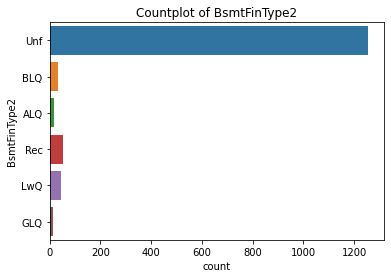

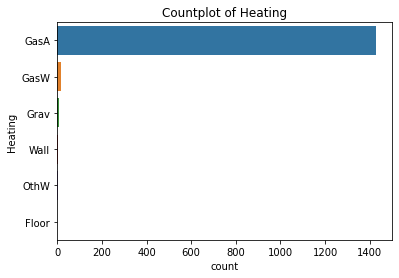

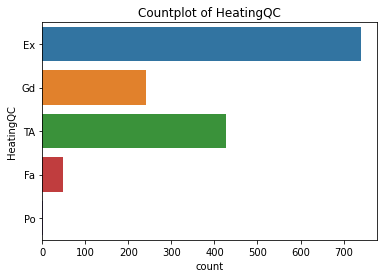

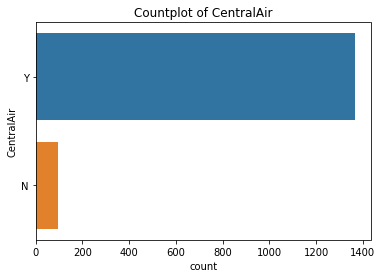

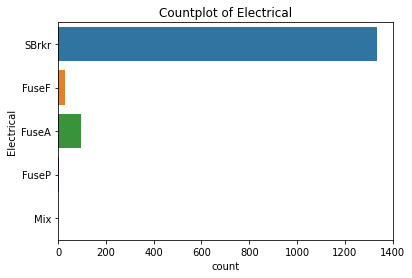

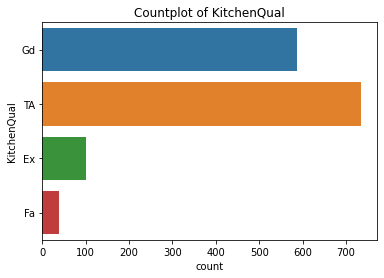

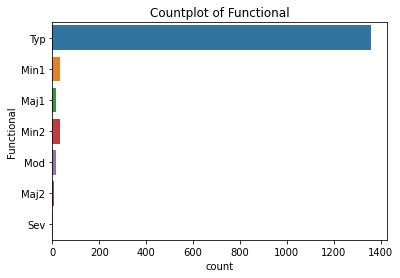

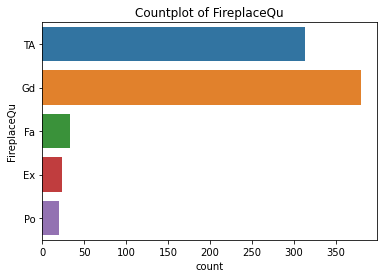

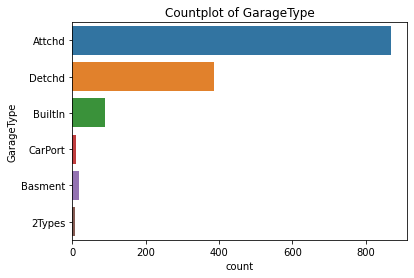

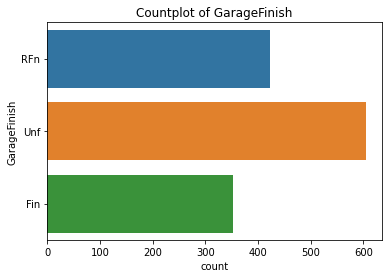

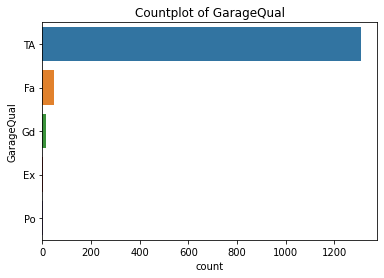

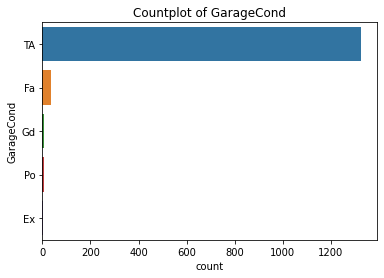

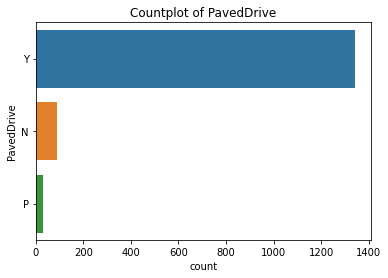

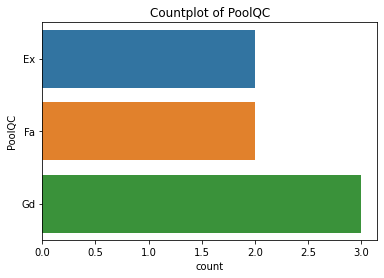

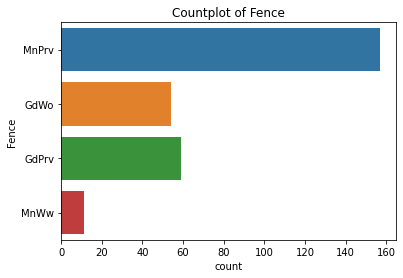

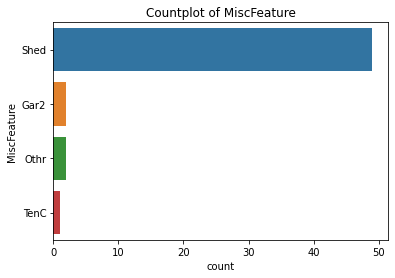

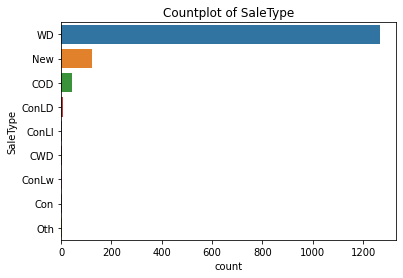

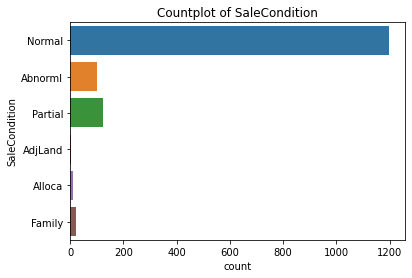

In [17]:
# plotting categorical features using countplot
for feature in cat_features:
    plt.title(f'Countplot of {feature}')
    sns.countplot(y=train[feature])
    plt.show()

In [18]:
# dropping columns with missing values more than 50% with and Id columns
train=train.drop(['Id' ,'Alley' ,'PoolQC' ,'Fence' ,'MiscFeature'],axis=1)

In [19]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


## 3. Train - Test Split 


In [20]:
# separating dependent and independent features
target=train.SalePrice
train=train.drop('SalePrice',axis=1)

In [21]:
# train_test_split
from sklearn.model_selection import train_test_split

full_train_X,full_val_X,train_y,val_y=train_test_split(train,target,random_state=0,test_size=.2)

In [22]:
# separating numeric and categorical features
cat_cols=[col for col in full_train_X.columns if full_train_X[col].dtype=='object']
num_cols=[col for col in full_train_X.columns if full_train_X[col].dtype==('int','float')]

# combining both feature types
my_cols=cat_cols+num_cols


In [23]:
# making new dfs with combined cols
train_X=full_train_X[my_cols].copy()
val_X=full_val_X[my_cols].copy() 



## 4. Pipelines and ColumnTransformer

In [24]:
# importing libararies

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression

# making pipeline for imputing, scaling & reducing features with PCA
num_transformers=Pipeline(steps=[
    ('num_imputer',SimpleImputer(strategy='median')),
    ('num_scaler',StandardScaler()),
#     ('pca',PCA(n_components=7))
])



# making pipeline for imputing & encoding categorical features 
cat_transformer= Pipeline(steps=[
    ('cat_imputer',SimpleImputer(strategy='most_frequent')),
    ('cat_encoder',OneHotEncoder(handle_unknown='ignore'))
])


# doing preprocessing on features using ColumnTransformer 
preprocessor = ColumnTransformer(
    transformers=[
        ('num',num_transformers,num_cols),
        ('cat',cat_transformer,cat_cols)
    ])




## 5. Model building using Pipelines

In [25]:
# making model with XGBoost

from xgboost import XGBRegressor

xgb_model=XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3,
             max_delta_step=0, max_depth=12, min_child_weight=4,
             monotone_constraints='()', n_estimators=300, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [26]:
# making final pipeline with XGBoost model

xgb_pipe=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',xgb_model)
])

In [27]:
xgb_pipe.fit(train_X,train_y) 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',...
    

In [28]:
xgb_pred=xgb_pipe.predict(val_X)

In [29]:
from sklearn.metrics import r2_score, mean_absolute_error

mae_score=mean_absolute_error(xgb_pred,val_y)
R2_score=r2_score(xgb_pred,val_y)

print(f'XGB MAE : {mae_score}')
print(f'XGB R2 Score: {R2_score}')

XGB MAE : 18393.917861729453
XGB R2 Score: 0.8484133610575502


In [30]:
# making model with Random Forest

from sklearn.ensemble import RandomForestRegressor

rfr_model=RandomForestRegressor(n_estimators=300,min_samples_leaf=3,min_samples_split=2,random_state=0,max_depth=12)

In [31]:
# making final pipeline with RandomForest
rfr_pipe=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',rfr_model)
])

In [32]:
rfr_pipe.fit(train_X,train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',...
    

In [33]:
rfr_pred=rfr_pipe.predict(val_X)

In [34]:
rfr_mae_score=mean_absolute_error(rfr_pred,val_y)
rfr_r2_score=r2_score(rfr_pred,val_y)

print(f'RFR R2 Score: {rfr_r2_score}')
print(f'RFR MAE Score : {rfr_mae_score}')

RFR R2 Score: 0.7891023340927084
RFR MAE Score : 17748.304345171066


In [35]:
# making model with LightGBM

import lightgbm as lgb

lgb_model=lgb.LGBMRegressor(n_estimators=500,learning_rate=.35 ,random_state=0)

In [36]:
# making final pipeline with LightGBM
lgb_pipe=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',lgb_model)
])

In [37]:
lgb_pipe.fit(train_X,train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',...
    

In [38]:
lgb_pred=lgb_pipe.predict(val_X)

In [39]:
lgb_mae_score=mean_absolute_error(lgb_pred,val_y)
lgb_r2_score=r2_score(lgb_pred,val_y)

print(f'LGB R2 Score: {lgb_r2_score}')
print(f'LGB MAE Score : {lgb_mae_score}')

LGB R2 Score: 0.8639939491889057
LGB MAE Score : 18361.092321236858


## 6. Plotting predicted SalePrice of all models

<AxesSubplot:title={'center':'Distibution of Predicted SalePrice using XBGBoost'}, ylabel='Count'>

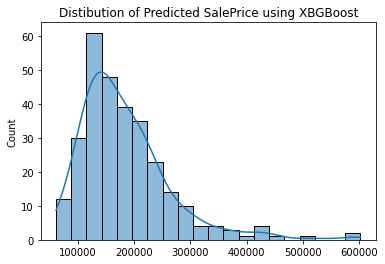

In [40]:
# plotting predicted saleprice with XGBoost

plt.title("Distibution of Predicted SalePrice using XBGBoost")
sns.histplot(xgb_pred,kde=True)


<AxesSubplot:title={'center':'Distibution of Predicted SalePrice using Random Forest'}, ylabel='Count'>

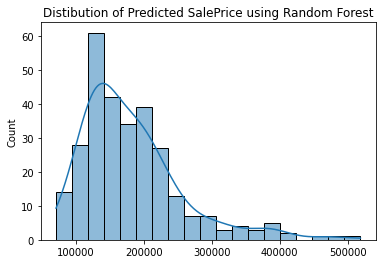

In [41]:
 # plotting predicted saleprice with RandomForest

plt.title("Distibution of Predicted SalePrice using Random Forest")
sns.histplot(rfr_pred,kde=True)

<AxesSubplot:title={'center':'Distibution of Predicted SalePrice using LightGBM Forest'}, ylabel='Count'>

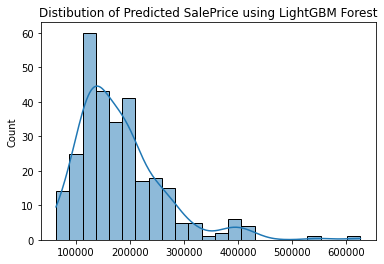

In [42]:
# plotting predicted saleprice with LightGBM

plt.title("Distibution of Predicted SalePrice using LightGBM Forest")
sns.histplot(lgb_pred,kde=True)

## 7. Loading test dataset

In [43]:
# loading test data
test_data=pd.read_csv(r'../input/home-data-for-ml-course/test.csv')

In [44]:
# making copy of test data as test
test=test_data.copy()

## 8. EDA on Test data

In [45]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1459.0,2190.000000,421.321334,1461.0,1825.50,2190.0,2554.50,2919.0
MSSubClass,1459.0,57.378341,42.746880,20.0,20.00,50.0,70.00,190.0
LotFrontage,1232.0,68.580357,22.376841,21.0,58.00,67.0,80.00,200.0
LotArea,1459.0,9819.161069,4955.517327,1470.0,7391.00,9399.0,11517.50,56600.0
OverallQual,1459.0,6.078821,1.436812,1.0,5.00,6.0,7.00,10.0
OverallCond,1459.0,5.553804,1.113740,1.0,5.00,5.0,6.00,9.0
YearBuilt,1459.0,1971.357779,30.390071,1879.0,1953.00,1973.0,2001.00,2010.0
YearRemodAdd,1459.0,1983.662783,21.130467,1950.0,1963.00,1992.0,2004.00,2010.0
MasVnrArea,1444.0,100.709141,177.625900,0.0,0.00,0.0,164.00,1290.0
BsmtFinSF1,1458.0,439.203704,455.268042,0.0,0.00,350.5,753.50,4010.0


In [46]:
test.nunique()

Id               1459
MSSubClass         16
MSZoning            5
LotFrontage       115
LotArea          1106
                 ... 
MiscVal            26
MoSold             12
YrSold              5
SaleType            9
SaleCondition       6
Length: 80, dtype: int64

In [47]:
# making list of numeric and categorical features
test_num_features=test.select_dtypes(('int','float')).columns
test_cat_features=test.select_dtypes('object').columns 



## 9. Plotting test data features

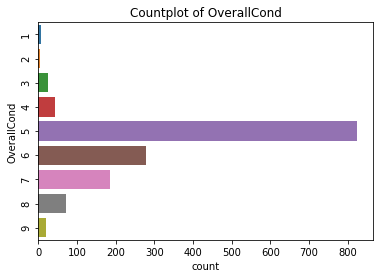

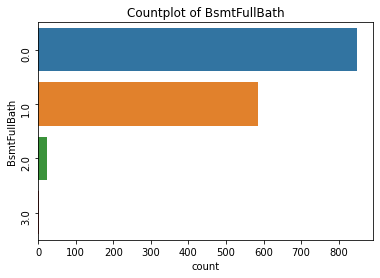

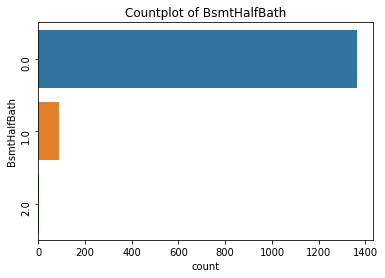

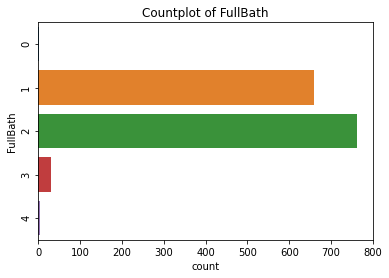

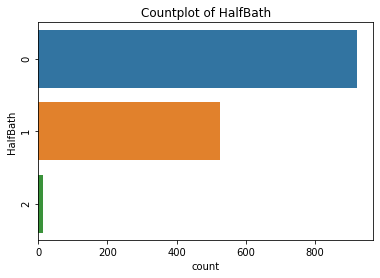

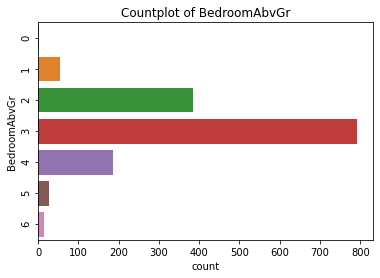

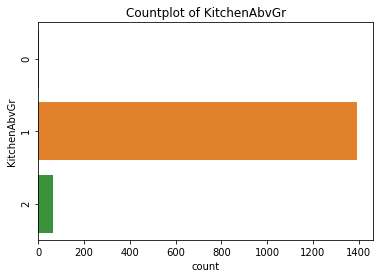

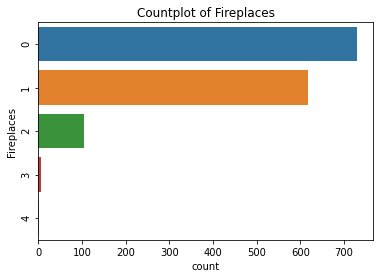

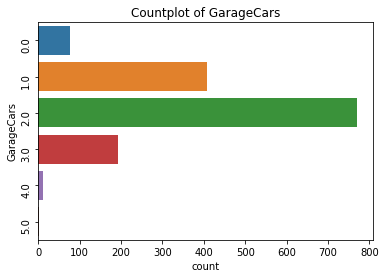

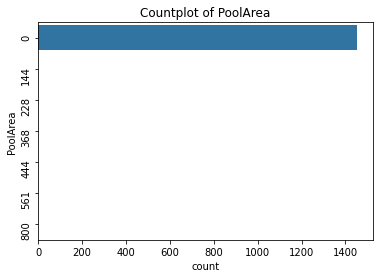

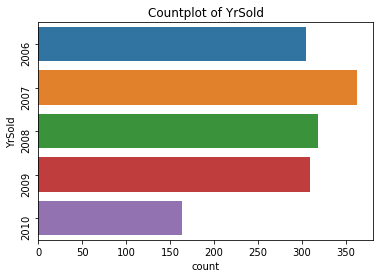

In [48]:
# plotting numeric features with less than 10 unique values with countplot
for feature in test_num_features:
    if test[feature].nunique()<10:
        plt.title(f'Countplot of {feature}')
        plt.yticks(rotation=90)
        sns.countplot(y=test[feature]) 
        plt.show()


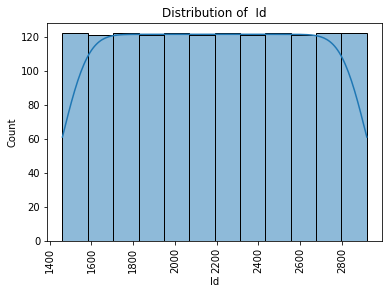

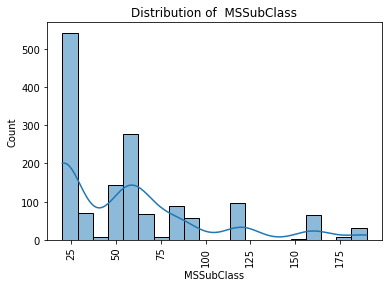

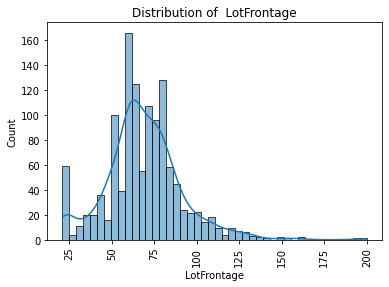

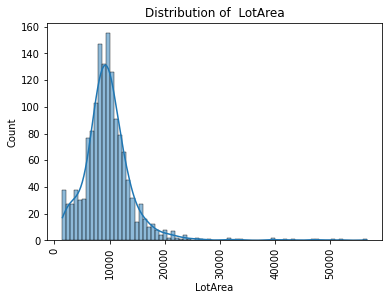

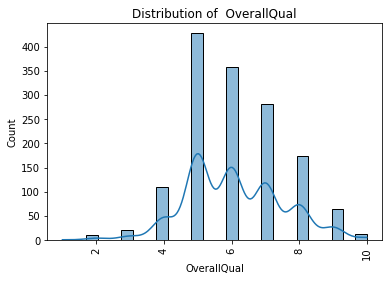

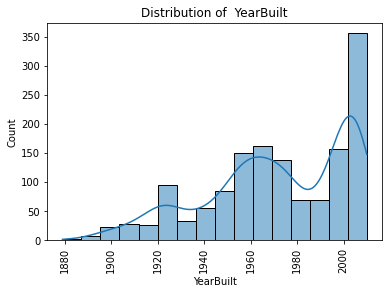

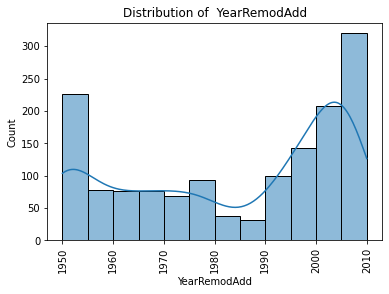

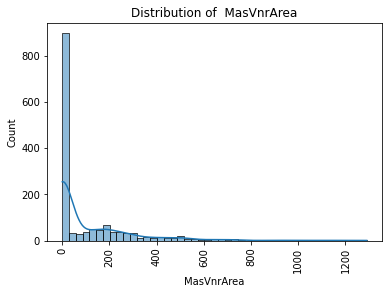

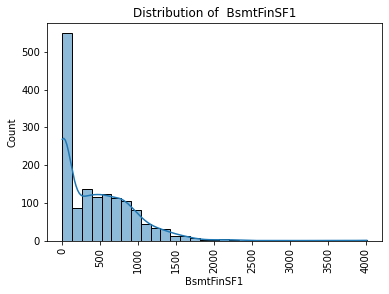

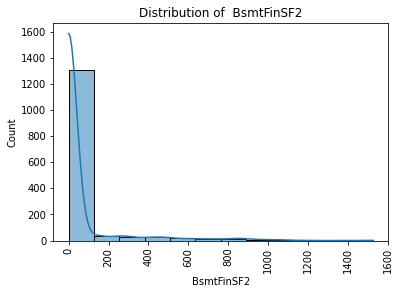

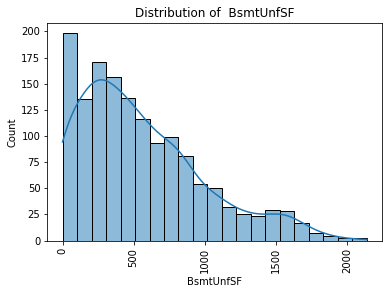

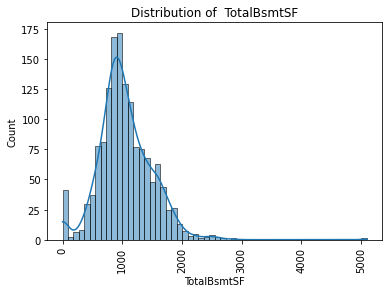

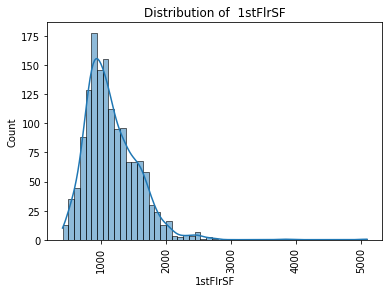

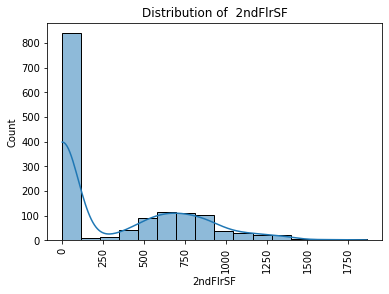

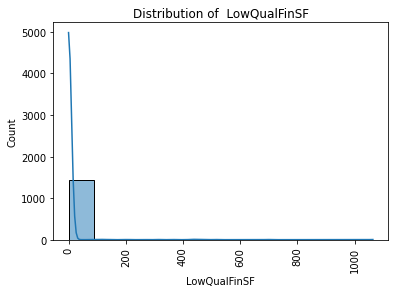

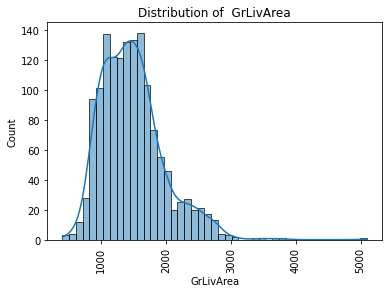

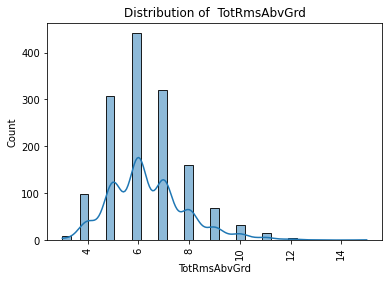

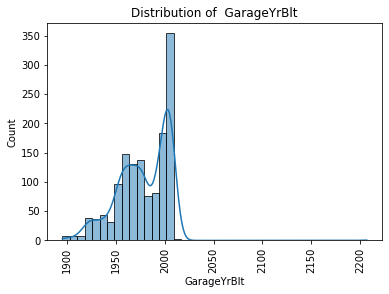

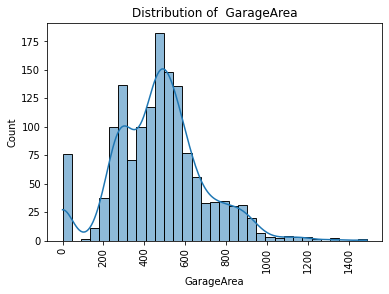

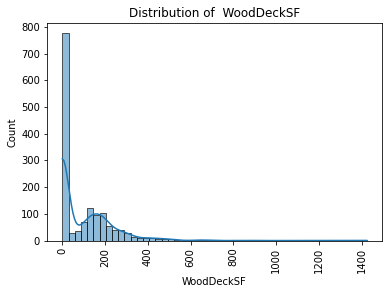

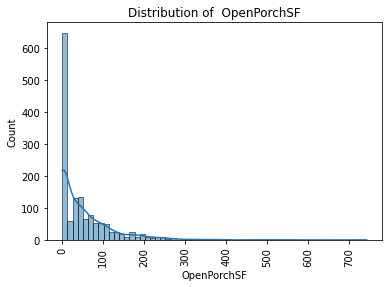

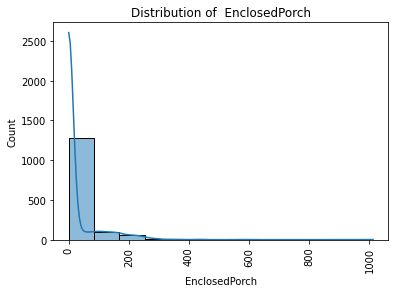

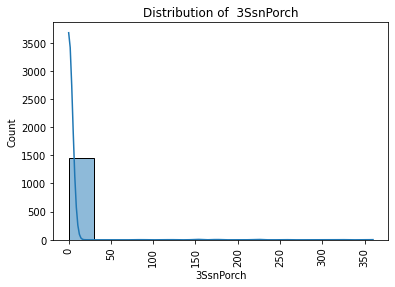

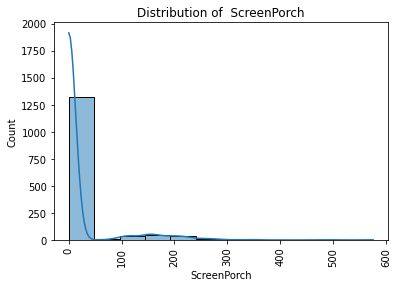

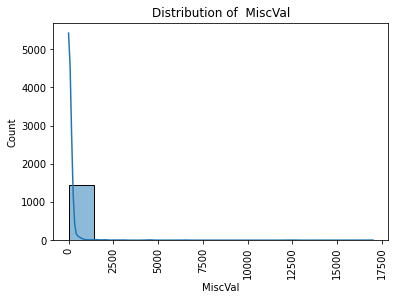

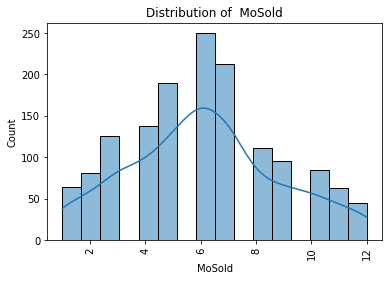

In [49]:
# plotting numeric features with 10 or more unique values with histogram
for feature in test_num_features:
    if test[feature].nunique()>=10:
        plt.title(f'Distribution of  {feature}')
        plt.xticks(rotation=90)
        plt.xlabel(feature)
        sns.histplot(x=test[feature],kde=True) 
        plt.show()

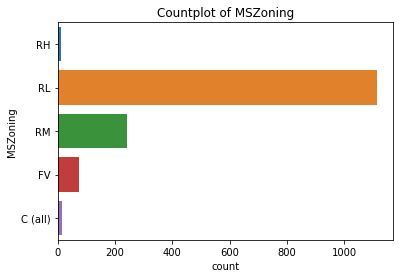

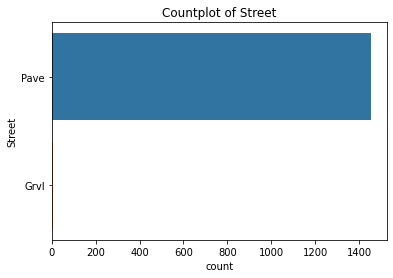

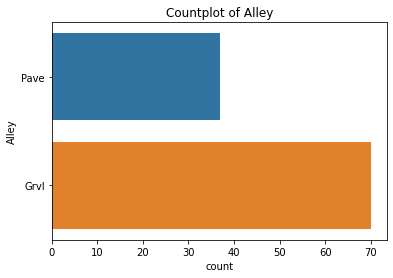

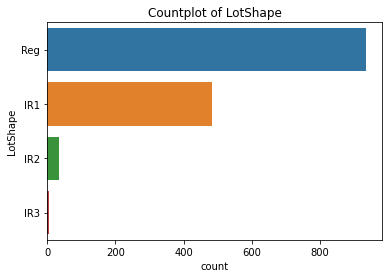

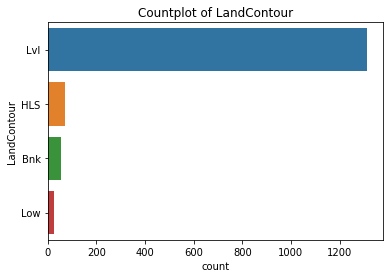

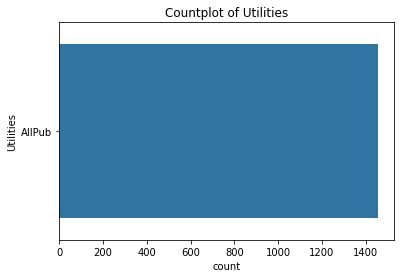

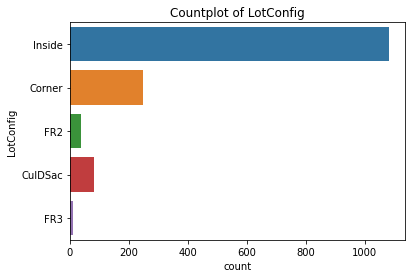

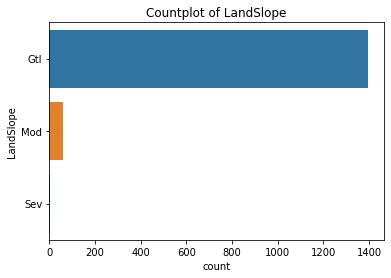

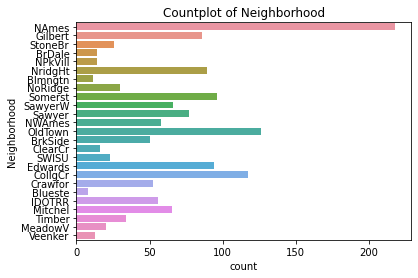

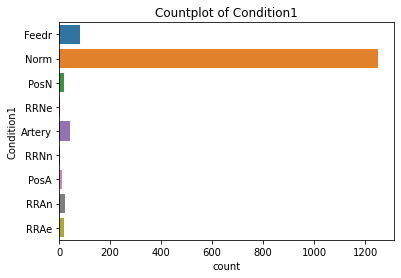

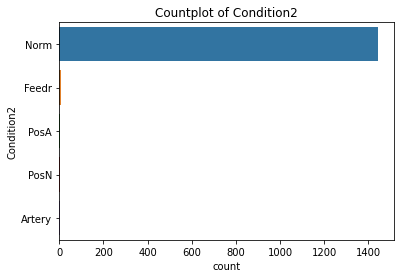

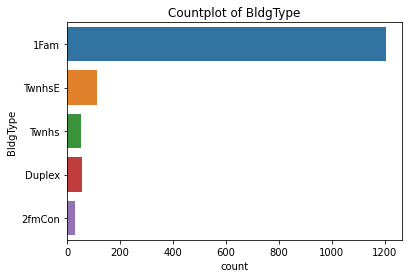

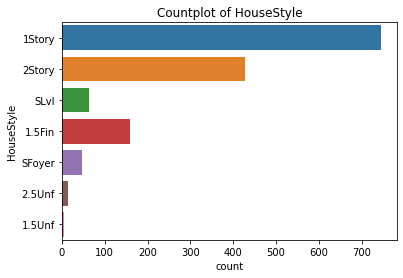

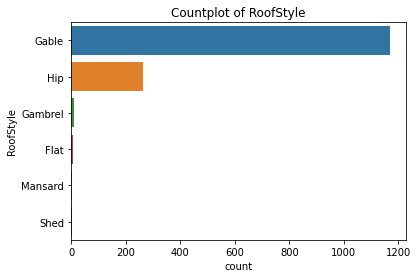

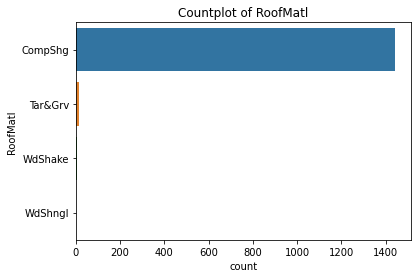

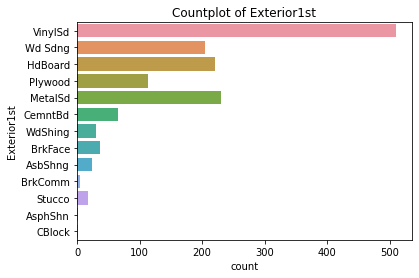

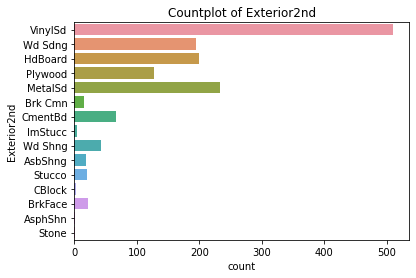

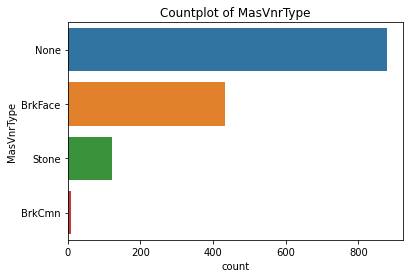

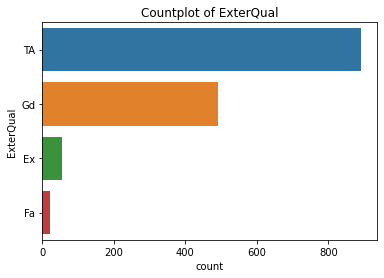

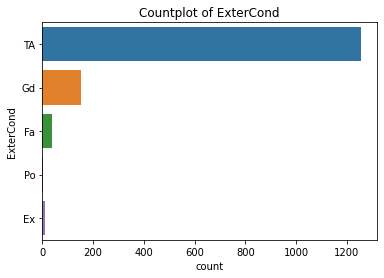

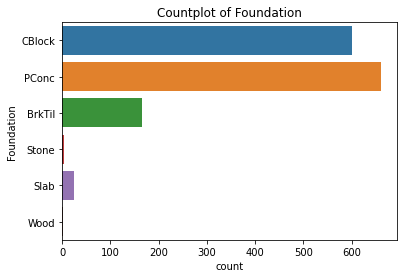

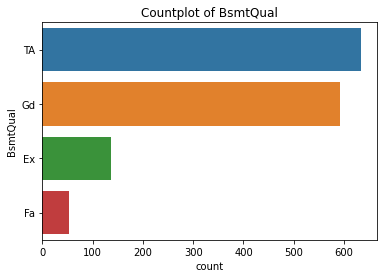

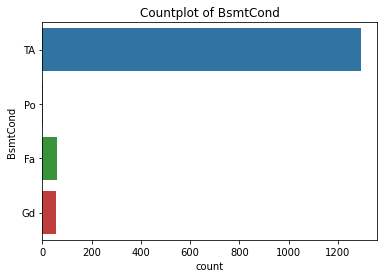

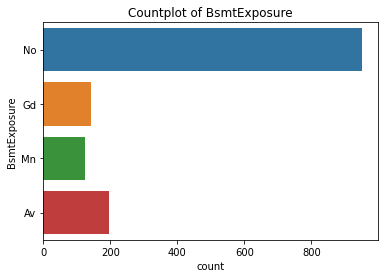

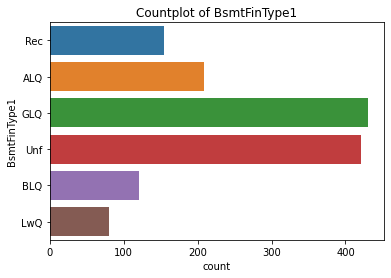

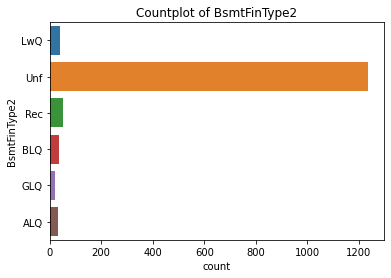

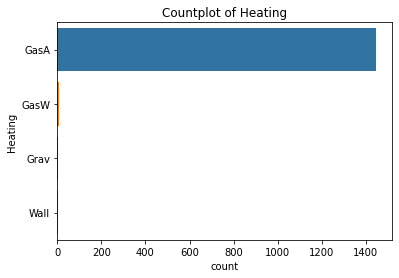

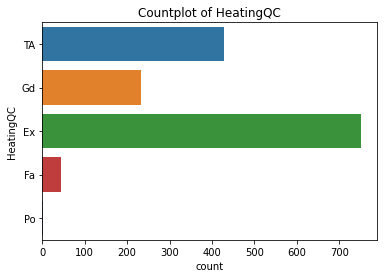

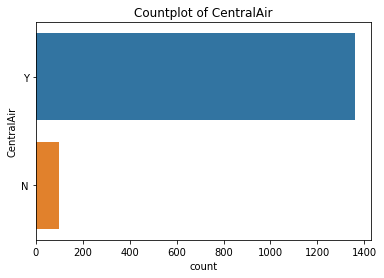

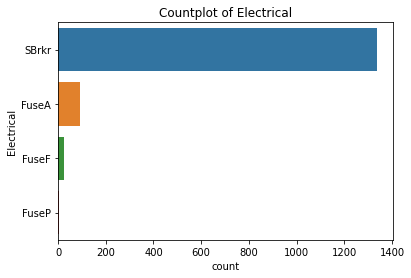

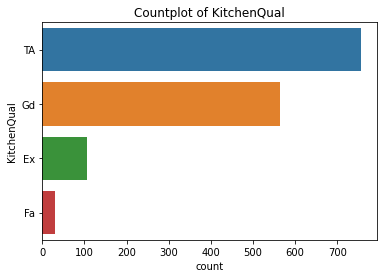

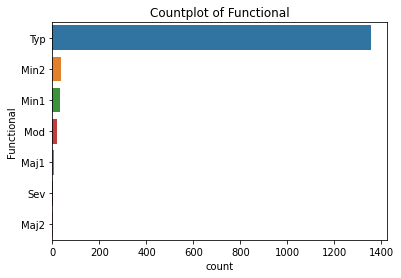

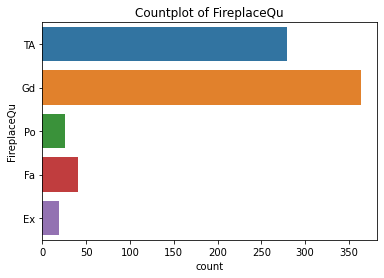

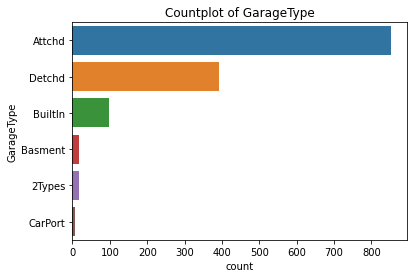

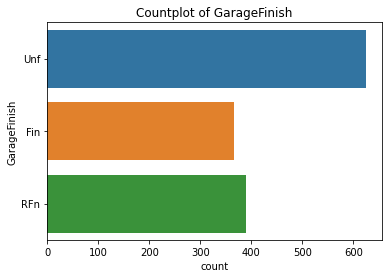

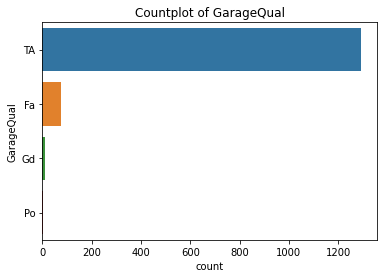

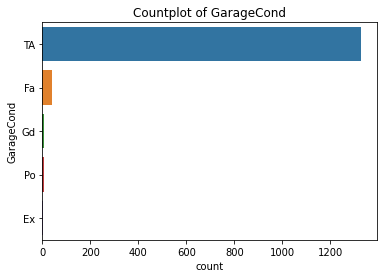

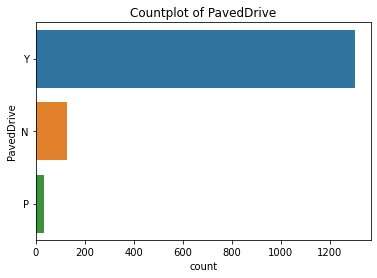

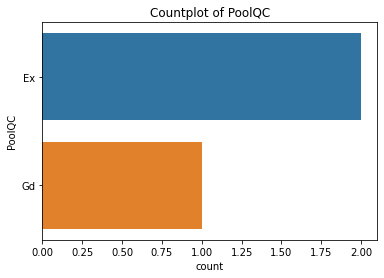

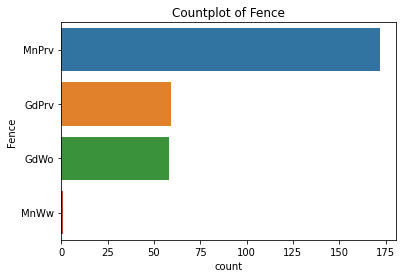

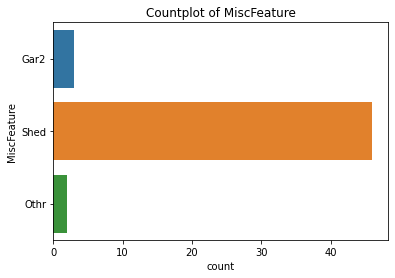

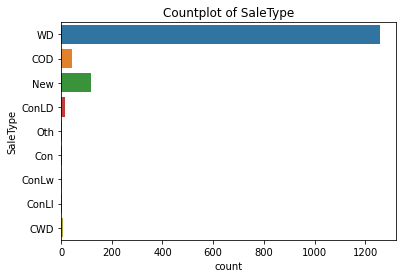

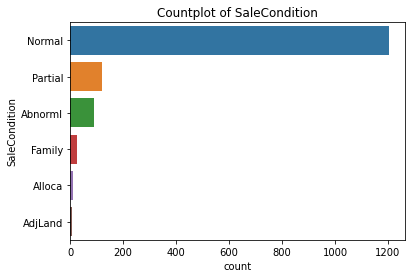

In [50]:
# plotting categorical features with countplot
for feature in test_cat_features:
    plt.title(f'Countplot of {feature}')
    sns.countplot(y=test[feature])
    plt.show() 

In [51]:
test[test_num_features].isnull().sum()

Id                 0
MSSubClass         0
LotFrontage      227
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea        15
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       2
BsmtHalfBath       2
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       78
GarageCars         1
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

In [52]:
test[test_cat_features].isna().sum()

MSZoning            4
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         16
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           44
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinType2       42
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
KitchenQual         1
Functional          2
FireplaceQu       730
GarageType         76
GarageFinish       78
GarageQual         78
GarageCond         78
PavedDrive          0
PoolQC           1456
Fence            1169
MiscFeature      1408
SaleType            1
SaleCondition       0
dtype: int64

In [53]:
# dropping columns with more than 50% nan values and Id column
test=test.drop(['Id' ,'Alley' ,'PoolQC' ,'Fence' ,'MiscFeature'],axis=1) 


## 10. Final model building on test data

In [54]:
# using xgb_pipe to fit whole training dataset
rfr_pipe.fit(train,target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',...
    

In [55]:
# using xgb_pipe to predict SalePrice for test data
test_pred=rfr_pipe.predict(test) 

<AxesSubplot:title={'center':'Distibution of Test SalePrice Prediction'}, ylabel='Count'>

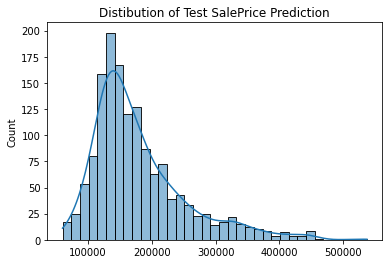

In [56]:
# plotting predicted SalePrice for test data
plt.title('Distibution of Test SalePrice Prediction')
sns.histplot(test_pred,kde=True)

## 11. Submission

In [57]:
# creating new df for submission
submission=pd.DataFrame({'Id':test_data.Id,'SalePrice':test_pred})
submission

,Id,SalePrice
0,1461,127604.374064
1,1462,156236.760233
2,1463,179273.299343
3,1464,180794.845951
4,1465,199998.947036
...,...,...
1454,2915,84927.596130
1455,2916,86477.716566
1456,2917,153570.924070
1457,2918,114547.984897


In [58]:
# converting df into csv file
submission.to_csv('submission.csv',index=False)